# Desktop DNS Notebook 1

This notebook and associated python code has been written by 
Andrew Wheeler, Engineering Department, University of Cambridge, aw329@cam.ac.uk

3DNS is a high-order DNS/LES solver suitable for turbomachinery and internal flows. The numerical scheme uses a 4-th order finite-difference discretization (Tamm & Webb) with an 8th order filter. Time integration is achieved with a 4-step Runge-Kutta cycle.

In this notebook, you will learn how to: 
* set-up an initial mesh and case files;
* run a case in 2D on your local machine;
* view the flow files

The example used here is for the 'Harrison' turbine blade cascade.  

## 1.1 Read in the profile
First we read in the blade profile. The format for the profile file is:

number of points\
pitch\
x y

In the script below, the coordinates are shifted so that the leading-edge is the origin, and scaled so that the axial chord is 1. It is good practise to normalize the geometry in this way. When setting the geometry, it is then relatively easy to set the computational mesh and topology set-up based on the axial chord.


In [1]:
%reload_ext autoreload
%autoreload 2


<function matplotlib.pyplot.show(close=None, block=None)>

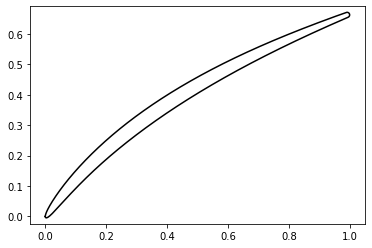

In [59]:
import matplotlib.pyplot as plt
from meshing.read_profile   import *
# pop-out figures
#%matplotlib qt
%matplotlib inline

# read in profile and normalize so that Cax=1.0 (normalization set to 'True')
xprof,yprof,pitch,stag=read_profile('geom/profile.txt',True)

# plot the profile to check
plt.figure(1)
plt.plot(xprof,yprof,'-k')
plt.axis('equal')
plt.show

When reading-in your own profile, you should check that the profile is well defined- are there sufficient points? is the surface curvature smooth? Check regions such as the trailing-edge and leading edge, and plot the curvature. 

This is particularly important for high-order finite difference schemes, where surface and mesh quality are very important.

In some cases you may need to re-generate the profile to ensure smoothness. 

***

## 1.2 Generate the topology and mesh

We first create a coarse mesh, defining the multi-block topology. A poisson solver is used to create a smooth multi-block mesh. It is much better to solve for the block boundaries using a very coarse mesh, and then refine this mesh, rather than solving for the block boundaries on a fine mesh.

This may take a few minutes. Wait for the cell to complete before moving to the next cell.

Now we can refine the mesh to create a baseline mesh for our initial simulations.

This may take a few minutes, depending on the level of refinement and smoothing iterations.

* It is best to start off with a relatively coarse mesh, even at this stage, when getting a new case established- so don't be too keen to ramp up the refinement factor at this point.

* Once you've got a coarse simulation running, it is relatively straight forward to interpolate this solution onto a finer a mesh and continue running. 

* Running a baseline case on a coarse mesh is useful because a lot of compute cost can be wasted in getting through transients and establishing a steady-state flow.


In [64]:


from meshing.blade_mesher import *
import timeit

# pop-out figures
%matplotlib qt
#%matplotlib inline

# inilitialize dictionaries
mesh   = {}
bcs    = {}
gas    = {}
solver = {}

# case name and profile coordinates
casename = 'notebook1'
mesh['case'] = casename
mesh['profile'] = 'geom/profile.txt'

# initial mesh inputs
mesh['npp'] = 2*[None]
mesh['ywall'] = 2*[None]
mesh['msmooths'] = 2*[None]

mesh['npp'][0] = 4
mesh['Lup'] = 1.0
mesh['Ldn'] = 1.0
mesh['Lo'] = 0.2
mesh['ywall'][0] = 0.04/150
mesh['msmooths'][0] = 500
mesh['cor_fac'] = 0.75 # factor shrinking multi-block corner cells - lower values give more shrinkage.

# final mesh inputs
mesh['npp'][1] = 28
mesh['refine_fac'] = 2 # 4
mesh['ywall'][1] =  0.01/150 # 0.01/150
mesh['msmooths'][1] = 100

# scale factor if used (set to 1.0 if not)
mesh['scale_factor'] = 1.0

# flip y coordinates
mesh['flip'] = 1

# solver inputs [SI-units]

# boundary conditions
bcs['Toin'] = 300.0 #K, initial guess of inlet total temp.
bcs['Poin'] = 100000.0 #Pa, initial guess of inlet total p.
bcs['pexit'] = 98590.0 #Pa, exit static p. 
bcs['vin'] = 70.0 #m/s, inlet velocity
bcs['alpha'] =  50.23 #degrees, inlet yaw angle  
bcs['gamma'] = 0.0 #degrees, inlet pitch angle
bcs['aturb'] = 0.0 # amplification factor for turbulence
bcs['lturb'] = 0 # not used
bcs['ilength'] = 500 # inlet turbulence generation frequency (no. steps)
bcs['radprof'] = 0 # impose spanwise profile when = 1.
bcs['twall'] = -1.0 # not used
bcs['cax'] = 1.0 # not used


# gas properties
gas['gamma']=1.4   # adiabatic exponent
gas['cp'] = 1005.0 # J/kg/K
gas['mu_ref'] = 3.2e-4 # scale ref. viscosity to match Re
gas['mu_tref'] = 273.0 # Sutherland's Tref
gas['mu_cref'] = 110.4 # Sutherland's Cref
gas['pr'] = 0.72 # Prandtl number


# solver inputs
solver['niter'] = 100000
solver['nwrite'] = 1000
solver['ncut'] = 10000000 # write cut file frequency    
solver['cfl'] = 1.0
solver['sigma'] = 0.03 # filter coefficient
    
solver['irestart'] = 0 # no re-start
solver['span'] = 0.2 # spanwise extent for 3D calcs - typically 10-20% of chord
solver['fexpan'] = 1.0 # must be 1.0

solver['nk'] = 1 # spanwise points for 3D calculation 
solver['npp'] = 1 # not used for gpu version
solver['istats'] = 0 # 0=no time averaging, 1=3D time average, 2=2D time average
solver['version'] = 'gpu' # write inputs for gpu version of the solver
                
# define block groups for each GPU card
block_groups = 1*[None] # 1 block group 
# blocks in each block group
block_groups[0] = {}
block_groups[0]['blocks'] = [1,2,3,4,5,6,7,8,9]
solver['block_groups'] = block_groups
solver['nkproc'] = 1 # GPUs in spanwise direction

total_GPUs = solver['nkproc']*len(block_groups) # total number of GPUs
            
start = timeit.default_timer()

# create mesh and initial case files
blk = blade_mesher(mesh,bcs,gas,solver)

stop = timeit.default_timer()

print('Time: ', stop - start)  



Writing inputs for 3dns_gpu
Total ij points
259504
Total GPUs
1
Time:  133.99863211804768


## 1.4 Create the case files
Now we're ready to create case files for the 3DNS solver with the baseline mesh. 

* These set-up a 2D case. We will start with a 2D case. Later we will extrude the solution in the spanwise direction to run a 3D case once we have a 2D flow established. This reduces the compute cost of the initial transient. 

* We'll set-up a case running at low Reynolds number, by running with an increased viscosity. Again, this helps us to run on a coarse mesh so that we can race through the pressure transients.

* The solver uses characteristic boundary conditions, which determine the rates of change of the flow properties at the inlet and exit. The way these are implemented is to fix the inlet entropy and inlet velocity. This means that the inlet stagnation conditions are only weakly imposed- the values inputted in the input file below set an initial state. 

* Later you can check what the stagnation conditions at inlet converge to once the flow has reached a statistically converged state. 

* When setting your boundary conditions below, make sure that the inlet velocity is compatible with the pressure ratio chosen- otherwise you can set-up a horrendous transient which will take a long time to settle down.


### Create initial guess using streamline curvature method

In [65]:
#%reload_ext autoreload
#%autoreload 2
from meshing.initial_guess import *
from meshing.write_flo import *
from meshing.read_case import *
from meshing.write_case import *

casename = 'notebook1'

# read casefiles
case = read_case(casename)

# create initial guess (last two integers define the streamline curvature grid dims)
prop = initial_guess(mesh,blk,bcs,gas,30,20)

# write initial flow files
write_flo(prop,casename)



gpu input file found
2
gpu input file found
2


### Check initial flow and exit pressure. Update case files

In [67]:
import numpy as np
import matplotlib.pyplot as plt

from postpro.read_flo import *
from postpro.plot_flo import *

# read initial flow and compute derived quantities
prop,geom = read_flo(casename)

# adjust exit pressure according to initial guess pexit 
pexit = np.mean(prop[8]['p'][:,:,-1])

# adjust inlet total pressure with assumed loss coefficient
Yp = 0.025
Poin = bcs['Poin']
Toin = bcs['Toin']
vin = bcs['vin']
gam = gas['gamma']
cp = gas['cp']
cv = cp/gam
rgas = cp - cv
ro = Poin/(rgas*Toin)

poin = bcs['Poin'] + Yp*vin*vin*ro*0.5


print('initial guess for pexit = ', pexit, 'Pa')
print('pexit in case file = ',case['bcs']['pexit'],'Pa')

print('initial guess for poin = ', poin, 'Pa')
print('Poin in case file = ',case['bcs']['Poin'],'Pa')


# update bcs using initial guess rounded to nearest pascal
case['bcs']['Poin'] = np.floor(poin)
case['bcs']['pexit'] = np.floor(pexit)

# set restart flag to restart from initial flow
case['solver']['irestart'] = 1 # 

# write new case files
write_case(case)

# plot flow
plot_flo(prop,geom,'mach',[0.0,0.3])
    


gpu input file found
2
initial guess for pexit =  98554.27995290657 Pa
pexit in case file =  98554.0 Pa
initial guess for poin =  100071.10281923715 Pa
Poin in case file =  100071.0 Pa
Writing inputs for 3dns_gpu
Total ij points
259504
Total GPUs
1


<module 'matplotlib.pyplot' from '/home/aw329/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

## Running a preliminary 'steady' calculation 

In this part we'll use a simple RANS model to establish a steady solution for the flow. This will give a starting point for the unsteady simulations and also help us assess the mesh resolution.

In [2]:
from meshing.write_rans import *

casename = 'notebook1'

rans = {}

rans['if_rans'] = 1
rans['speed_up'] = 10.0

write_rans(casename,rans)



### Run the code

Navigate to the case directory. In this example it's

> cd notebook1

You'll need an NVIDIA GPU 


Choose the right executible, depending on your machine or VM instance you are running on 



| VM instance            | executible   |
|------------------------|--------------|
|                        | threedns_    |


Either copy the solver executible ('threedns') into your case directory or add it to your bin. Then run the code with:

> mpirun -np 1 threedns

This runs the code on 1 processor. You can increase the number of GPUs you wish to run on (provided you have access to more cards), but you need to first modify the input file ('input_gpu.txt'). We'll do this later.


The baseline case will run for 10,000 iterations, and should take only a few minutes to complete.


Check the GPU 
> nvidia-smi



### View the flow

We can now read in the flow-field and check everything seems OK. You should see the starting vortex just leaving the trailing-edge. The flow needs much longer to establish itself. Getting through the transients can often be one of the more challenging aspects of setting up a DNS or LES case.

In [92]:
import numpy as np
from postpro.read_flo import *
from postpro.plot_flo import *

casename = 'notebook1'

# pop-out figure
%matplotlib qt
#%matplotlib inline


# read flow - prop and geom are dictionaries containing the flow and grid
prop,geom=read_flo(casename)

# plot_flo(prop,geom,plot_var,caxis)
#plot_flo(prop,geom,'mach',[0.0,0.3])
#plot_flo(prop,geom,'p',[0.96e5,1.0e5])
#plot_flo(prop,geom,'mut_model',[0.0,200.0])
#plot_flo(prop,geom,'po',[0.99e5,1.001e5])
plot_flo(prop,geom,'vortz',[-2000.0,2000.0])



gpu input file found
2


<module 'matplotlib.pyplot' from '/home/aw329/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

Plot the loading

In [93]:
import matplotlib.pyplot as plt

wall_blocks = [3,4,5,7]

plt.figure(1)
for i in wall_blocks:
    plt.plot(geom[i-1]['x'][:,-1],prop[i-1]['p'][:,-1,0],'k.')

plt.show()


## Plot the monitor file

In [114]:
from postpro.plot_monitor import *

plot_monitor(casename);

gpu input file found
2


In [82]:
from postpro.boundarylayer import *


bl =boundarylayer(casename);

gpu input file found
2
gpu input file found
2


In [83]:
plt.figure(1)
plt.plot(bl['ss']['x'],bl['ss']['xplus'],'-k.')
plt.plot(bl['ss']['x'],bl['ss']['yplus'],'-b.')
plt.title('suction surface')
plt.show()


plt.figure(2)
plt.plot(bl['ps']['x'],bl['ps']['xplus'],'-k.')
plt.plot(bl['ps']['x'],bl['ps']['yplus'],'-b.')
plt.title('pressure surface')
plt.show()

This shows us that the wall normal resolution is probably ok (for now) but we need to increase the streamwise resolution quite significantly to ensure properly resolved results. For now, however, it's useful to work with an under resolved mesh and then refine once we are happy with the set-up. Later we will interpolate the flow onto a more refined mesh; running on a coarse mesh helps to establish a baseline flow.
***


## Run an unsteady calculation
Now we can restart the solution and run for 100,000 iterations. First we need to modify the solver input file.


### Re-start from the preliminary steady RANS case

In [76]:
from meshing.read_case import *
from meshing.write_case import *
from meshing.write_rans import *

casename = 'notebook1'

# read case
case = read_case(casename)

# adjust iterations 
case['solver']['niter'] = 100000 # total number of iterations
case['solver']['irestart'] = 1 # restart the calculation with irestart=1

# write new case files
write_case(case)


# switch rans mode off
rans = {}
rans['if_rans'] = 0
rans['speed_up'] = 1.0

write_rans(casename,rans)



gpu input file found
2
Writing inputs for 3dns_gpu
Total ij points
259504
Total GPUs
1


Now restart the simulation. You may wish to store the initial RANS solution in a separate folder for use later.

In [113]:
import numpy as np
from postpro.read_flo import *
from postpro.plot_flo import *

casename = 'notebook1'

# pop-out figure
%matplotlib qt
#%matplotlib inline


# read flow - prop and geom are dictionaries containing the flow and grid
prop,geom=read_flo(casename)

# plot_flo(prop,geom,plot_var,caxis)
#plot_flo(prop,geom,'mach',[0.0,0.3])
plot_flo(prop,geom,'vortz',[-2000.0,2000.0])


wall_blocks = [3,4,5,7]

plt.figure(2)
for i in wall_blocks:
    plt.plot(geom[i-1]['x'][:,-1],prop[i-1]['p'][:,-1,0],'k.')

plt.show()

gpu input file found
2


Some unsteadiness is expected because of the strong vortex shedding from the trailing-edge and the formation of separation bubbles on the suction and pressure surfaces.

In a two-dimensional flow there is no breakdown to turbulence and therefore ,,,


### Create a movie of the flow

In [53]:
case['solver']['ncut'] = 1000 # write cut file frequency    
case['solver']['niter'] = 100000 # write cut file frequency    

# write new case files
write_case(case)


Writing inputs for 3dns_gpu
Total ij points
259504
Total GPUs
1



Restart the simulation. Once the simulation is complete, run the cell below to produce the snapshots of the flow from the 'kcut' files.


In [65]:
from postpro.read_kcuts import *

# create image files from the kcut files
read_kcuts(casename,[1000],'p',[0.98e5-1000.0,0.98e5+1000.0]);



gpu input file found
2


Install ffmpeg

https://ffmpeg.org/download.html

Use the following command in the notebook1 directory

> ffmpeg -framerate 10 -pattern_type glob -i '*.png'   -c:v libx264 -pix_fmt yuv420p out.mp4

This creates a video from the image files, called out.mpeg. Read the ffmpeg documentation if you wish to adjust the video quality and frame rate.





In [112]:
from postpro.plot_monitor import *

plot_monitor(casename);

gpu input file found
2


Now the input file has been modified, run the solver again. This time it may take a few hours to complete. 


* Every time the solver writes out the flow files you can take another look at the flow- do this by re-running the cell above in 1.6.

* Watch-out for when the starting vortex hits the exit boundary- this is a common cause for simulation failure, because the characteristic interfaces can fail when hit by such a strong pressure field.

* As the flow develops, notice how coherent 2D roll-ups form on the suction surface and in the trailing-edge vortex shedding. Because the flow is purely 2D, there can be no 3D turbulent breakdown. This means that unsteady structures are very intense and tend not to dissipate. You'll also notice how the vortices interact with each other, causing a very non-uniform flow at the exit. These flow features are largely a consequence of running in 2D- when we run in 3D with inflow turbulence these structures will be far less intense.

In the next notebooks you'll
* set-up the case on your HPC system
* start running in 3D
* add inflow turbulence
* start gathering statistics.

For the next few notebooks you need access to an HPC system and for running larger cases, so get yourself set-up:

A few options are available. You may wish to purchase a GPU accelerated machine 

https://www.hpc.cam.ac.uk/applications-access-research-computing-services

Notice oblique waves - these are remnants of pressure waves generated when the flow is initiated - the inlet and outlet boundaries are non-reflective to plane waves parallel to the boundaries, however oblique waves pass unaffected by the periodic interfaces, eventually dieing out  

Pressure waves are also generated from vortex formation on the blade surface and the trailing-edge you can see these in the pressure contours. 
